# 写在前面

本课程设计的题目：爬取携程或去哪儿酒店的评论数据，分析酒店的星级、评分、地理位置、卫生条件等各种因素与客户好评之间的关系，还有酒店对客户的回复分析。

作为对题目的回应，本实验最终解决了这些问题：1.哪些因素对用户好评的影响最大？2.哪些因素对差评的影响最大？3.不同因素的和用户打分的相关性如何？4.酒店的回复有什么特点？

我的整体思路是，将这些因素量化成数值，然后研究因素和用户打分（1-5）之间的相关性，根据相关性分析的结论，最终给六大因素（服务、价格、地理位置、卫生、食物、设施）进行排序。这里就涉及到情感分析的一些技术，包括情感对象的识别、情感极性的判断、情感程度的计算，以及统计学上的相关性分析。

在情感分析上，本实验采用的是构建情感词典结合规则的方法。

经过调查，已有情感分析的研究有一些不足。一个是粒度上，大多数情感分析的工具和模型只用于预测整段文本的情感倾向，而不是预测一段文本的不同方面的倾向，也就是说，粒度不够精细。另一个是精度上，对于情感倾向的预测只停留在正向/负向/中立等一些大的倾向，而没有精确到程度。本模块就是用情感字典的方法解决这两个问题。

在方法上，情感分析一般采用的有两种，基于机器学习的（包括深度神经网络），基于字典的。前者依赖人工标注，并训练模型，然后利用模型预测的结果计算情感值。它的弊端是要标数据、解释性不强、准确率可能不高。后者不需要训练模型，而是采用情感词典和规则相结合的方法。虽然规定的制定是个耗费心神的工作，但是它的解释性很强，对于一些具体的、小型的任务而言，有天然的优势。
（参考文献：https://dl.acm.org/doi/10.1002/asi.21662 ）


在相关性分析上，我采用定量和定性相结合的分析方法。

首先假定这些因素和用户打分是相互独立的随机变量，于是可以用统计学的相关系数（皮尔逊相关系数、斯皮尔曼相关系数、肯德尔相关系数）衡量各个因素和打分的相关性，从而发现哪些因素对打分的影响较大，哪些因素的影响较小。（参考文献：https://arxiv.org/abs/2110.00821） 。此外，还使用工具，将各个因素的分值分布可视化，从而能更直观地研究因素和用户打分之间的关系。

尽我所知，在已有的文献中，不乏方面级的情感分析，也不乏情感程度的计算，但是将这些技术结合，并且将结果用于与其他变量的相关性分析，本实验应该是第一个。

结论为：
1.因素与打分的相关性排序为：服务>位置>卫生>设施≈价格>食物 
2.位置对好评的影响最大
3.设施、卫生对差评的影响最大
4.服务、价格和食物在各个分数段都受到同样的关注 
5.酒店回复具有同质化特征。

结论虽然不是很成熟，但也希望能给情感分析研究者或酒店的运营者提供一些帮助。

最后，欢迎您对我的工作进行评价，提出宝贵的建议！

# 用selenium爬取评论

In [1]:
from selenium import webdriver
from msedge.selenium_tools import Edge, EdgeOptions
from selenium.webdriver import Firefox
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import pandas as pd
import os
import csv
import uuid

In [5]:
def get_one_page_comment(browser):
    soup = BeautifulSoup(browser.page_source, "lxml")
    review = soup.find_all("div", attrs={'class': 'm-reviewCard-item'})
    review_list = []
    for r in review:
        try:
            rvw = r.find_all("p")
            score = r.find_all("strong")
            
            if rvw[1].text == '艺龙网提供点评' or rvw[1].text == '去哪儿网提供点评':
                if len(rvw) == 3:
                    comment = rvw[2].text
                    reply = '无'
                    score = score[0].text
                elif len(rvw) > 3:
                    comment = rvw[2].text
                    reply = rvw[3].text
                    score = score[0].text
            else:
                if len(rvw) <= 2:
                    comment = rvw[1].text
                    reply = '无'
                    score = score[0].text
                elif len(rvw) > 2:
                    comment = rvw[1].text
                    reply = rvw[2].text
                    score = score[0].text

            review_list.append((score, comment, reply))
            
        except:
            pass
    return review_list

In [3]:
#启动浏览器，转到爬取页面
browser = Firefox()
url = "https://hotels.ctrip.com/hotels/detail/?hotelId=62541808&checkIn=2021-12-03&checkOut=2021-12-04&cityId=2&minprice=&mincurr=&adult=1&children=0&ages=&crn=1&curr=&fgt=&stand=&stdcode=&hpaopts=&mproom=&ouid=&shoppingid=&roomkey=&highprice=-1&lowprice=0&showtotalamt=&hotelUniqueKey="
browser.get(url)  # 跳转到酒店页面
browser.implicitly_wait(1)

In [250]:
# 爬取单个酒店
pagenum = 300  # 设置爬取的评论页数

temp_filename = str(uuid.uuid4())
save_name = 'data/' + temp_filename + '.csv' # 临时保存

for n in range(pagenum):
    # 爬取一页评论并保存
    with open(save_name, mode='a+', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        for r in get_one_page_comment(browser):
            writer.writerow(r)
    # 翻页
    browser.find_element_by_xpath('//i[@class="u-icon u-icon-arrowRight"]').click()
    browser.implicitly_wait(0.5)  # 隐式等待1秒
    print("第{}页".format(n))
    time.sleep(1)  # 等待1秒

第0页
第1页
第2页
第3页
第4页
第5页
第6页
第7页
第8页
第9页
第10页
第11页
第12页
第13页
第14页
第15页
第16页
第17页
第18页
第19页
第20页
第21页
第22页
第23页
第24页
第25页
第26页
第27页
第28页
第29页
第30页
第31页
第32页
第33页
第34页
第35页
第36页
第37页
第38页
第39页
第40页
第41页
第42页
第43页
第44页
第45页
第46页
第47页
第48页
第49页
第50页
第51页
第52页
第53页
第54页
第55页
第56页
第57页
第58页
第59页
第60页
第61页
第62页
第63页
第64页
第65页
第66页
第67页
第68页
第69页
第70页
第71页
第72页
第73页
第74页
第75页
第76页
第77页
第78页
第79页
第80页
第81页
第82页
第83页
第84页
第85页
第86页
第87页
第88页
第89页
第90页
第91页
第92页
第93页
第94页
第95页
第96页
第97页
第98页
第99页
第100页
第101页
第102页
第103页
第104页
第105页
第106页
第107页
第108页
第109页
第110页
第111页
第112页
第113页
第114页
第115页
第116页
第117页
第118页
第119页
第120页
第121页
第122页
第123页
第124页
第125页
第126页
第127页
第128页
第129页
第130页
第131页
第132页
第133页
第134页
第135页
第136页
第137页
第138页
第139页
第140页
第141页
第142页
第143页
第144页
第145页
第146页
第147页
第148页
第149页
第150页
第151页
第152页
第153页
第154页
第155页
第156页
第157页
第158页
第159页
第160页
第161页
第162页
第163页
第164页
第165页
第166页
第167页
第168页
第169页
第170页
第171页
第172页
第173页
第174页
第175页
第176页
第177页
第178页
第179页
第180页
第181页
第182页
第183页
第184页


ElementClickInterceptedException: Message: Element <i class="u-icon u-icon-arrowRight" type="arrowRight"> is not clickable at point (1547,981) because another element <div class="m-nearbyHotels_box"> obscures it


# 数据预处理

In [29]:
# 合并所有csv到raw data.csv
comments = []
comment_ids = set()
cnt = 0
for file in os.listdir('data'):
    if file.split('.')[-1] == 'csv':
        with open('data/' + file, newline='', encoding='utf-8') as f:
            reader = csv.reader(f)
            for row in reader:
                if row[1] not in comment_ids:
                    comment_ids.add(row[1])
                    row[1] = row[1].replace('\n','').replace('\r','') # 去除文本中的换行符
                    row[2] = row[2].replace('\n','').replace('\r','')
                    comments.append(row)

with open('raw data.csv', mode='w+', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['score', 'comment', 'reply'])
    for r in comments:
        writer.writerow(r)

In [131]:
# 查看score分布，并将数据平均化
df = pd.read_csv('raw data.csv')
score = df.value_counts('score').sort_index()
print(score)

print('mean:', df['score'].mean())
print('median:', df['score'].median())
print('var:', df['score'].var())

sampled_df = pd.read_csv('raw data.csv')

sampled_df.drop(sampled_df.groupby(['score']).get_group(1.0).index, axis=0, inplace=True)
sampled_df.drop(sampled_df.groupby(['score']).get_group(2.0).index, axis=0, inplace=True)
sampled_df.drop(sampled_df.groupby(['score']).get_group(4.0).index, axis=0, inplace=True)
sampled_df.drop(sampled_df.groupby(['score']).get_group(4.2).index, axis=0, inplace=True)
sampled_df.drop(sampled_df.groupby(['score']).get_group(4.5).index, axis=0, inplace=True)
sampled_df.drop(sampled_df.groupby(['score']).get_group(4.7).index, axis=0, inplace=True)
sampled_df.drop(sampled_df.groupby(['score']).get_group(5.0).index, axis=0, inplace=True)

sampled_df = sampled_df.append(df.groupby(['score']).get_group(1.0).sample(n=200, random_state=5, axis=0))
sampled_df = sampled_df.append(df.groupby(['score']).get_group(2.0).sample(n=200, random_state=5, axis=0))
sampled_df = sampled_df.append(df.groupby(['score']).get_group(4.0).sample(n=200, random_state=5, axis=0))
sampled_df = sampled_df.append(df.groupby(['score']).get_group(4.2).sample(n=200, random_state=5, axis=0))
sampled_df = sampled_df.append(df.groupby(['score']).get_group(4.5).sample(n=200, random_state=5, axis=0))
sampled_df = sampled_df.append(df.groupby(['score']).get_group(4.7).sample(n=200, random_state=5, axis=0))
sampled_df = sampled_df.append(df.groupby(['score']).get_group(5.0).sample(n=200, random_state=5, axis=0))

print('after sampling:')
score = sampled_df.value_counts('score').sort_index()
print(score)

print('mean:', sampled_df['score'].mean())
print('median', sampled_df['score'].median())
print('var:', sampled_df['score'].var())

sampled_df = sampled_df.reset_index(drop=True)
sampled_df.to_csv('sampled data.csv', index=False)

score
1.0     806
1.2      64
1.5     131
1.7     119
2.0     398
2.2     195
2.5     244
2.7     271
3.0     297
3.2     148
3.5     192
3.7     224
4.0     979
4.2     352
4.5     484
4.7     560
5.0    7825
dtype: int64
mean: 4.217254872450761
median: 5.0
var: 1.5428908381807631
after sampling:
score
1.0    200
1.2     64
1.5    131
1.7    119
2.0    200
2.2    195
2.5    244
2.7    271
3.0    297
3.2    148
3.5    192
3.7    224
4.0    200
4.2    200
4.5    200
4.7    200
5.0    200
dtype: int64
mean: 3.102496194824968
median 3.0
var: 1.3272166660177862


In [2]:
# 加载情感词典、停用词词典

# 加载词典的函数
def open_dict(which_dict):
    with open ('dict/' + which_dict + '.txt', 'r', encoding='utf-8') as f:
        words = f.readlines()
        words = [word.replace('\n','').replace('\r','') for word in words]
    return words

# 加载情感词典
# pos -> 1
# neg -> -1
# most -> *4
# very -> *3
# more -> *2
# inverse -> *-1
pos = open_dict('pos')
neg = open_dict('neg')
inverse = open_dict('inverse')
extreme = open_dict('extreme')
very = open_dict('very')
alittle = open_dict('a little')
service = open_dict('服务')
price = open_dict('价格')
food = open_dict('食物')
location = open_dict('位置')
facility = open_dict('设施')
neatness = open_dict('卫生')

aspect = service + price + food + location + facility + neatness
emotion = pos + neg
degree = inverse + extreme + very + alittle
hand_dict = aspect + emotion + degree

# 加载停用词词典
stopword_list = open_dict('stopwords')

# 分词
from zhconv import convert
import jieba

def tokenize(text):
    text = convert(text, 'zh-hans')
    seg_list = jieba.cut(text)
#     print('/ '.join(seg_list) + '\n')
    seg_list = [word for word in seg_list if ((word not in stopword_list) or (word in hand_dict))] # 保留不在停用词里的和在hownet里的
    return seg_list

In [3]:
# 查看分词结果

df = pd.read_csv('sampled data.csv', encoding='utf-8')
document = []
for text in df['comment']:
    seg_list = tokenize(text)
    print(text)
    print('')
    print(seg_list)
    print('')
    document.append(seg_list)
# print(len(document))

Building prefix dict from D:\anaconda3\lib\site-packages\jieba\dict.txt ...
Dumping model to file cache C:\Users\Derek\AppData\Local\Temp\jieba.cache
Loading model cost 1.2120869159698486 seconds.
Prefix dict has been built succesfully.


地角: 很不错 旁边就是永安百货 缺点 门口不许停车环境:可以 百年老楼错综复杂 🎤强烈推荐你们选靠近天梯的房间 缺点:隔音效果很不好 容易受到惊吓🎃服务: 个人不是很好 第一天去一楼吃早餐 服务人员态度很恶劣 我就告诉她没有位置 把餐桌收拾一下 她们就反复盘问你是那间房的 跟防贼似的 很让人生气服务二:房间错综复杂 就应该可以支持外卖送上楼的习惯 他家酒店不支持 去过大大小小那么多酒店 这是第一家不支持不推荐喜欢吃夜宵的朋友去她家 很不方便

['地角', '很', '不错', '旁边', '永安', '百货', '缺点', '门口', '不许', '停车', '环境', '可以', '百年老', '楼', '错综复杂', '强烈推荐', '选', '靠近', '天梯', '房间', '缺点', '隔音', '效果', '很', '不好', '容易', '惊吓', '服务', '个人', '不是', '很', '好', '第一天', '一楼', '吃', '早餐', '服务', '人员', '态度', '很', '恶劣', '告诉', '没有', '位置', '餐桌', '收拾', '一下', '反复', '盘问', '那间', '房', '防贼', '很', '生气', '服务', '二', '房间', '错综复杂', '应该', '可以', '支持', '外卖', '送', '上楼', '习惯', '他家', '酒店', '不', '支持', '去过', '大大小小', '多', '酒店', '这是', '第一家', '不', '支持', '不', '推荐', '喜欢', '吃', '夜宵', '朋友', '她家', '很', '不', '方便']

住了三天，办理入住时服务意识较差，餐厅和楼道服务员倒挺有礼貌，房间每天一早楼下轰隆轰隆，卫生间排气是坏的，除了位置，其它一般吧，500一晚也就那样了。

['住', '三天', '办理', '入住', '时', '服务', '意识', '较差', '餐厅', '楼道', '服务员', '倒', '挺', '礼貌', '房间', '每天', '一早', '楼下', '轰隆轰隆', '卫生间', '排气', '坏', '位置', '一般', '500', '一晚']

第一個房間，整晚都有濃郁的下水道的味道，實在受不

房间陈旧，狭小

['房间', '陈旧', '狭小']

比想象差的太多。

['想象', '差', '太', '多']

bad service

['bad', 'service']

前台接待没经过岗前培训，基本服务不熟悉

['前台', '接待', '没', '岗前', '培训', '基本', '服务', '不', '熟悉']

被蚊子和虫子折腾到凌晨五点，一句抱歉没有，换了个房间一样。

['蚊子', '虫子', '折腾', '凌晨', '五点', '一句', '抱歉', '没有', '换', '房间']

酒店很旧，人员很不专业，前台一个大个子工作人员，素面朝天，邋里邋遢的感觉🚗 交通：滴滴叫车很方便🧹卫生：第一天去了一趟位于大堂的卫生间，简直让人当场晕倒，仿佛五星级酒店的耻辱，脏的让人难以忘怀，已经快10点了，还没有打扫过，前台人员从里面出来，告诉我“可脏了”……无语，应该是没人管理的原因，导致我后来对房间也不太信任，觉得哪里都脏🍃环境：第一天的滴滴车司机告诉我们：这旁边就是八宝山公墓，本来肃然起敬……结果他继续说平时附近的人一个人都不敢住……正赶上第二天7月15,觉得整个人都不太好了，想马上走，司机还说：你们对面的商场，上次因为有确诊病例，当时封了好久……听见就很难受😣，司机一定是对这里有很大的恶意🔔服务：客房阿姨刷卡进入房间，看见有人说：你们不退房吗，我说不退，她出去了，后来说我们同行客人说退的，我们根本没有交过房卡，别人说一句就行。那么我想说这也行，那如果有人恶意找事情退房怎么办餐厅的早餐很敷衍了，酸奶是临近日期的，味道很一般，寿司简直比我做的还难看，厨师队伍不太给力，喝粥的家具实在太惨了

['酒店', '很', '旧', '人员', '很', '不', '专业', '前台', '一个', '大个子', '工作人员', '素面朝天', '邋里邋遢', '感觉', '交通', '滴滴', '叫车', '很', '方便', '卫生', '第一天', '一趟', '位于', '大堂', '卫生间', '简直', '当场', '晕倒', '仿佛', '五星级', '酒店', '耻辱', '脏', '难以忘怀', '已经', '快', '10', '点', '没有', '打扫', '前台', '人员', '里面', '告诉', '可脏', '无', '语

1.一股下水道味道、完全比不上装修好点的如家。2. 装修很老旧，我定的是套房，那沙发不忍直视，廉价反光的的确良面料一样😪😪3. 床很硬，4. 防疫做的防贼似的，刚出个门进来就，火眼金睛的盯着你，做个登记，不知道做一些有实质性有意义的事，人浮于事，流于形式，比如有时间可以把洗手间下水道味道想办法解决掉。我是你们老大，一个星期搞定，网上随便买点东西就解决。5. 交通不太方便，不能要求太多。整体感觉太差了，要是不是退房他们热情点，问感受怎么样，我会全部打1。全部真实感受。订了两晚，退了一晚。🤕🤕

['一股', '下水道', '味道', '完全', '比不上', '装修', '好点', '如家', '装修', '很', '老旧', '我定', '套房', '沙发', '不忍', '直视', '廉价', '反光', '的确良', '面料', '😪', '😪', '床', '很', '硬', '防疫', '做', '防贼', '刚出', '门', '进来', '火眼金睛', '盯', '做个', '登记', '不', '知道', '做', '一些', '实质性', '意义', '事', '人浮于事', '流于形式', '时间', '可以', '洗手间', '下水道', '味道', '想', '办法', '解决', '掉', '老大', '一个', '星期', '搞定', '网上', '随便', '买点', '东西', '解决', '交通', '不太', '方便', '不能', '要求', '太', '多', '整体', '感觉', '太差', '是不是', '退房', '热情', '点', '问', '感受', '我会', '全部打', '真实', '感受', '订', '两晚', '退', '一晚', '🤕', '🤕']

在这个酒店入住最起码50次以上，今天又入住，让前台送个早餐都不行，太不会做生意了，差评。

['酒店', '入住', '最起码', '50', '次', '今天', '入住', '前台', '送个', '早餐', '不行', '太', '不会', '做生意', '差评']

体验非常差  屋内环境不想说 洗个澡洗着洗着 水成了黑黄色 房内设施和图片差距很大 携程定的房 给的房间 我只想说呵呵了 上楼的时候看见五楼有人下了 装修 房门都不一样 不知道是携程


['前台', '女生', '态度', '很', '好', '男生', '很差', '问好', '不会', '客人', '手机', '五星', '宾馆', '态度', '楼层', '服务', '检查', '是否', '做', '房间', '卫生', '多', '一会', '不行', '擅自', '开门', '喊', '一下', '洗澡', '直接', '套', '裤子', '赶过去', '藏', '门', '沟通', '不会', '电话', '问', '一下', '哪家', '宾馆', '干']

3星级吧，床很硬，后换到楼上行政房床好一些。单是也就是3-4星水平。和5星没关系，地毯式的地板太脏了，设备老久，要想住五星的感觉，这里肯定不行

['星级', '床', '很', '硬', '后换', '楼上', '行政', '房床', '好', '一些', '单是', '星', '水平', '星', '没关系', '地毯式', '地板', '太脏', '设备', '老久', '想', '住', '五星', '感觉', '肯定', '不行']

进去时房间内有股很大的烟味，后来发现被子也有烟味。天知道被子洗了没有。第二天出去玩了之后，下午3点回房间时，发现房间还没有打扫，打电话才有人来打扫，给人的印象很不好。另外，房间的插头很少，带了两部手机一个充电宝，夜间充电要到处找电插座。其中有一个查座还无法使用（插不进去），不得不把充电宝放在卫生间充电。

['进去', '时', '房间内', '有股', '很大', '烟味', '后来', '发现', '被子', '烟味', '天知道', '被子', '洗', '没有', '第二天', '出去玩', '之后', '下午', '点回', '房间', '时', '发现', '房间', '没有', '打扫', '打电话', '有人', '打扫', '印象', '很', '不好', '房间', '插头', '很少', '带', '两部', '手机', '一个', '充电', '宝', '夜间', '充电', '到处', '找', '电插座', '一个', '查座', '无法', '使用', '插', '不', '进去', '不得不', '充电', '宝', '放在', '卫生间', '充电']

本次武汉暂住，选择了这个酒店。酒店的位置比

原本觉得五一出行能订到位置不错且价格公道的五星级酒店觉得是蛮划算蛮期待的 但事实却是让人失望不止亿点点 啊……这………首先来说酒店与地铁站和商场相连是蛮方便蛮好的地理位置 虽然外观整体略显陈旧 但总体来说还是中规中矩的1⃣️一来到酒店一楼的gs/concierge还算是蛮热情的指引至25楼办理c/i  还是不错的2⃣️顺利上楼后来到大堂 客人并不多也没有排长队的现象 但大堂的gr只是傻傻的杵在那里看到我上来后并没有指引也没有反应 别过头就走了 我看前台那边好像还在忙就不知所措的在大堂中心站了许久 额…无语子3⃣️最后只能自己看到好像没人以后差缝前去询问 前台只有三个员工 有两个员工在对课办理手续 还有一个我也不知道她在忙什么 前面没客人也不接受我的入住办理请求 只说要等一会儿 只能接着等了 后来终于轮到了 前台办理过程全程冷漠 提出了想要不靠近电梯的合理需求得到了极其不耐烦的敷衍回复 而且最后上楼才发现要求被忽略了根本就没听进去（前台作为门面 小姐姐却连个职业假笑也不愿意给 而且态度还……无语子）对了 还有就是上海早已实施酒店不主动提供六小件政策 但在前台办理手续时有的主动询问有的没有提及 这是…差别对待吗？4⃣️有点糟糕地回到房间 对于要求被忽视的种种anyway也是不想再讨论了 但我万万没想到等着我的还有更大无语事件。既然前台没有询问六小件那我就自己打电话去总机要呗 习惯性的除了要牙具还会一次性的把需要的amenity要完 毕竟知道housekeeping在节假日也是不容易的 打完电话以后就静心等待了 十分钟二十分钟过去了 我打电话催了一次 一接电话感知到不是先前的接线员并让他查看我的记录 没想到有需要再重复一遍我要的东西 简直是惊了……这算是工作失误了吧 说了再看看后我也只能再等 三十分钟时我在催促了一次 没想到我需要不断向不同的接线员重复我的需求 要一次客用品足足重复了三四次 感觉可以列为工作重大失误了5⃣️在等待客用品送达时例行会在使用房间前巡视一下卫生情况 床上用品大体是整齐的 但地毯除尘感觉欠缺了一点 墙壁上和沙发包括书写的圆桌也有明显打扫不干净的痕迹 再移步至洗漱间问题也是不止亿点 倒不是说吹毛求疵在鸡蛋里挑骨头 但着实是让人很难忽视啊 玻璃和镜面的设计相较于瓷砖而言真的让没擦拭干净的水渍无处遁形 确实是很膈应且看着很马虎很不干净6⃣️最后一点小小建

我这次住过双人床和单人床的。单人床比双人床的房间大，可是布置更简单了。我觉得还是有点贵。早餐还可以，种类繁多。甜的多。没想到咖啡里已放糖了。

['住', '双人床', '单人床', '单人床', '双人床', '房间', '大', '布置', '更', '简单', '觉得', '有点', '贵', '早餐', '可以', '种类', '繁多', '甜', '多', '没想到', '咖啡', '里', '放糖']

酒店设施很旧，服务也一般，外卖都不能帮着送到房间，真是第一次遇到过这样的酒店

['酒店设施', '很', '旧', '服务', '一般', '外卖', '不能', '帮着', '送到', '房间', '真是', '第一次', '遇到', '这样', '酒店']

🚌位置交通：临时决定来北京旅游，比较仓促，选择了一个出行比较方便，地理位置比较好的酒店。对面就有商场，边上就是便利店。500m之内就有地铁5号线和2号线。到景点什么都比较方便🏠房间设施：房间除了墙重新刷过的感觉看起来新一点别的桌子衣橱洗手间什么的都非常的陈旧。窗手柄也没有，根本关不紧，有一条缝就一直在漏风，只能拉着窗帘挡着。衣橱的门关不上还一直自己会打开有点恐怖[撇嘴]你们听到背景的声音是冰箱，睡眠浅的人晚上根本别想睡[流泪]洗澡的下水也是非常差，基本洗了2分钟开始就可以泡脚了。还有房卡、简直无力吐槽，一共住了4天有3天是开不了门的[抓狂]每天景点逛的很累了，好不容易回到酒店，到了门口还要折返下楼换卡，真的非常糟糕！💁‍♂️服务：服务只能说一般，写着24小时前台，晚上十二点房间里的电话已经打不到前台了！一开始以为是房间电话坏了，第二天早上打了才发现不是电话坏了，是有意被切断的。所以晚上大家真的有急事的话记得自己下楼找前台哦！关于一次性用品，大家记得自己要带好哦～平时出门我们都会带着牙刷拖鞋什么到。这次老公剃须刀忘带了前台直接回绝说没有，可是你们自己明明写着可以向前台索取的呀，没有的话写着干嘛呢[抠鼻]娱乐设施有个桌球台，本来感觉还不错。但是这个开放时间真的是完全看服务员心情。第一天我们晚上十点去的，前面有客人在玩久等了一会儿，快23:30的时候就有服务员来说十二点就结束哦。第二天九点半下来前台直接说九点就结束了。那我前一天是在别的地方玩的？🧹卫生：因为没什么需要整理的，所以前几天一直是没让阿姨

没吃早餐，可以加床

['没', '吃', '早餐', '可以', '加床']

客房设备声音太吵

['客房', '设备', '声音', '太吵']

几年前为了看如恩的设计，入住过几次贝尔特酒店。这次由于看漏了信息，不小心订了间大床套房，经携程工作人员多次沟通后，酒店方亦无论如何不给取消也没有房间可以更换，来到酒店入住后，工作人员办理入住和退房也也没有应有的职业态度及素养，也许是为了和酒店日益渐衰的环境匹配吧，套房的设计和设施已经让人不忍直视了（套房的客房设计应该与如恩设计公司无关）。给携程工作人员的尽职尽责满分，酒店本身和工作人员的服务已经让酒店不再值得住。

['几年', '前', '看如恩', '设计', '入住', '几次', '贝尔特', '酒店', '看漏', '信息', '不', '小心', '订', '间', '大床', '套房', '携程', '工作人员', '多次', '沟通', '酒店', '方亦', '无论如何', '不', '取消', '没有', '房间', '可以', '更换', '来到', '酒店', '入住', '工作人员', '办理', '入住', '退房', '没有', '应有', '职业', '态度', '素养', '也许', '酒店', '日益', '渐衰', '环境', '匹配', '套房', '设计', '设施', '已经', '不忍', '直视', '套房', '客房', '设计', '应该', '如恩', '设计', '公司', '无关', '携程', '工作人员', '尽职尽责', '满分', '酒店', '工作人员', '服务', '已经', '酒店', '不再', '值得', '住']

比较陈旧，

['比较', '陈旧']

地理位置优越 对面就是地铁站，附近吃饭方便，新世界百货 国瑞商城在对面。性价比比较高，已经多次入住，外国游客多，美中不足 网络不太稳定，另外拖鞋质量有待提高。

['地理位置', '优越', '对面', '地铁站', '附近', '吃饭', '方便', '新世界', '百货', '国瑞', '商城', '对面', '性价比', '比较', '高', '已经', '多次', '入住', '外国游客', '多', '美中不足', '网络', '不太', '稳定', '拖鞋', '质量',

酒店设施算新并且这个价格性价比很高，因为在附近出差所以住那。评分低是因为我在熟睡的状态被陌生人闯入。吓的我大喊谁啊，只能听到关门声和一个女声：不好意思。当时真的吓得六神无主了。心里想的就是幸亏我醒了。恍了半天神才想起来给前台打电话让他们帮我查下什么情况。查了后告诉我是服务员进错房间了。我说我是从里边反锁的呀，为什么能进来？来了服务人员看了房门后发现防盗链和门锁都是坏的。请问房门坏的不维修么？门是坏的就敢给住客住？如果是图谋不轨的人得到了房卡那不是轻松就可以打开房门么？房门坏被服务员开错门这个概率应该相当小了吧。总之细思极恐，真的不敢往下想了。可以从视频里看出我当时手都是抖的，而且当时的方法应该不对，我应该拧外边的门把手。当时真的已经吓傻了，服务员的态度我就不多说了。都毫无安全意识，只知道怪服务员开错门了。并没有认识到对住客带来的伤害和门锁坏的危险。酒店可以住，但请大家一定一定在住进去的时候检查门锁！为了自己的安全。

['酒店设施', '算新', '价格', '性价比', '很', '高', '附近', '出差', '住', '评分', '低', '是因为', '熟睡', '状态', '陌生人', '闯入', '大喊', '只能', '听到', '关门声', '一个', '女声', '不好意思', '当时', '真的', '六神无主', '心里', '想', '幸亏', '我醒', '恍', '半天', '神才', '想', '起来', '前台', '打电话', '帮', '查下', '情况', '查', '告诉', '服务员', '进错', '房间', '说', '是从', '里边', '反锁', '进来', '服务', '人员', '房门', '发现', '防盗链', '门锁', '坏', '请问', '房门', '坏', '不', '维修', '门', '坏', '敢', '住客', '住', '图谋不轨', '得到', '房卡', '不是', '轻松', '可以', '打开', '房门', '房门', '坏', '服务员', '开错', '门', '概率', '应该', '相当', '小', '细思极', '恐', '真的', '不敢', '往下', '想', '可以', '视频', '里', '看出', '当时', '手', '抖', '当时', '方法'

酒店位置挺好，旁边就是雪松路美食街，很多有名的店都在那条街上，晚上很热闹，吃的很方便；出行离取水楼地铁口也不远，门口去江边的公交车也很多；武汉到处在修路，晚上也施工，晚上睡觉还是有点吵，酒店卡片提示准备了耳塞，去前台问说没有了；房间的卫生还要提高，挪了下床，床下面好脏。

['酒店', '位置', '挺', '好', '旁边', '雪松', '路', '美食街', '很多', '有名', '店', '那条', '街上', '晚上', '很', '热闹', '吃', '很', '方便', '出行', '取水', '楼', '地铁口', '不远', '门口', '江边', '公交车', '很多', '武汉', '到处', '修路', '晚上', '施工', '晚上', '睡觉', '有点', '吵', '酒店', '卡片', '提示', '准备', '耳塞', '前台', '问说', '没有', '房间', '卫生', '还要', '提高', '挪', '下床', '床', '下面', '好脏']

问题很大，1前台小哥把有人住的房卡给了我，这表现酒店管理好业余。2被单充满了八四消毒水味，但床单发现了上个客人的头发，这被单多久换一次呢？3房子给错房卡，送的椰汁，还是山寨品牌……喝了一口像“六个核桃”……酒店管理者，你们这是想倒闭吗？再来武汉不会住的……

['问题', '很大', '前台', '小哥', '有人', '住', '房卡', '表现', '酒店', '管理', '好', '业余', '被单', '充满', '八四', '消毒水', '味', '床单', '发现', '客人', '头发', '被单', '多久', '换', '一次', '房子', '错', '房卡', '送', '椰汁', '山寨', '品牌', '喝', '一口', '六个', '核桃', '酒店', '管理者', '想', '倒闭', '武汉', '不会', '住']

早餐一般，没啥好吃的东西。酒店设施齐全，位置还可以周边配套设施一应俱全。总体来说还是比较一般的感觉。

['早餐', '一般', '没', '好吃', '东西', '酒店设施', '齐全', '位置', '可以', '周边', '配套', '设施', '一应俱全', '总体', '比较', '一般', '感觉']

入住当

早餐品种还行，服务态度不错。

['早餐', '品种', '行', '服务态度', '不错']

公寓式酒店，房间卫生可以，走廊卫生差，卫生间一般

['公寓式', '酒店', '房间', '卫生', '可以', '走廊', '卫生', '差', '卫生间', '一般']

早餐其差，晚上很吵，真的不推荐住在这里，价格也不便宜，唯一的好处就是附近很繁华。可以逛逛，性价比真的不好！

['早餐', '其差', '晚上', '很', '吵', '真的', '不', '推荐', '住', '价格', '不', '便宜', '唯一', '好处', '附近', '很', '繁华', '可以', '逛逛', '性价比', '真的', '不好']

酒店设施陈旧很多年了入住还碰上装修

['酒店设施', '陈旧', '很多年', '入住', '碰上', '装修']

一般般 性价比不高

['一般般', '性价比', '不高']

北京的酒店好贵，和江浙酒店比性价比太低

['北京', '酒店', '好贵', '江浙', '酒店', '性价比', '太低']

早餐还行，服务质量还行。

['早餐', '行', '服务质量', '行']

房间蛮大的就是有点陈旧

['房间', '蛮大', '有点', '陈旧']

位置好，离三里屯酒吧街很近。老房子改造。很大，有冰箱洗衣机、微波炉等。房间还算舒适。设施一般。性价比较高。

['位置', '好', '三里屯', '酒吧街', '很近', '老房子', '改造', '很大', '冰箱', '洗衣机', '微波炉', '房间', '算', '舒适', '设施', '一般', '性价比', '较', '高']

前台服务员服务一般

['前台', '服务员', '服务', '一般']

设施陈旧，一般。

['设施', '陈旧', '一般']

附近就医，价格贵

['附近', '就医', '价格', '贵']

设施陈旧，wifi 信号差，周边商业区弥补了酒店的缺点

['设施', '陈旧', 'wifi', '信号', '差', '周边', '商业区', '弥补', '酒店', '缺点']

I stayed here for four nights. Service was good, and a really nice guy 

不是一般的差，我都不知道那些住过的人是咋想的，还好评，卫生差的不是一点，设施老旧的简直没法用

['不是', '一般', '差', '不', '知道', '住', '想', '好评', '卫生', '差', '不是', '一点', '设施', '老旧', '简直', '没法用']

房屋内部清理不足，感觉较脏乱，酒店位于老城区，停车场太小，到店时没有车位且酒店无法给我解决，周边停车场全是收费的，后自行停车一晚上停车场收费50元。

['房屋', '内部', '清理', '不足', '感觉', '较', '脏乱', '酒店', '位于', '老城区', '停车场', '太小', '店', '时', '没有', '车位', '酒店', '无法', '解决', '周边', '停车场', '全是', '收费', '自行', '停车', '晚上', '停车场', '收费', '50', '元']

酒店太老了，房间臭脚丫子的味道熏人啊，睡觉塞着鼻孔，不推荐

['酒店', '太老', '房间', '臭', '脚丫子', '味道', '熏人', '睡觉', '塞着', '鼻孔', '不', '推荐']

这是我最差的一次体验，房间设施成就不说，完全没有服务，充电器，雨伞全部统统都收费，被子还带着一股霉味，半夜把人都熏醒的那种，无法入睡。房间卫生没有，简直对维也纳酒店的一种耻辱，维也纳总部估计只收加盟费，不参与管理的那种。太无语了。

['最差', '一次', '体验', '房间', '设施', '成就', '不说', '完全', '没有', '服务', '充电器', '雨伞', '统统', '收费', '被子', '带', '一股', '霉味', '半夜', '熏醒', '那种', '无法', '入睡', '房间', '卫生', '没有', '简直', '维也纳', '酒店', '一种', '耻辱', '维也纳', '总部', '估计', '只收', '加盟费', '不', '参与', '管理', '那种', '太无语']

卫生极差，实在太差了卫生极差，实在太差了卫生极差，实在太差了卫生极差，实在太差了卫生极差，实在太差了

['卫生', '极差', '实在', '太差', '卫生', '极差', '实在', '太差', '卫生', '极差', '实在', '太差', '卫生

酒店是不错，携程服务垃圾，我是钻石会员，霸王条款！所有条款都是有利于携程！任何责任都是客户的！

['酒店', '不错', '携程', '服务', '垃圾', '钻石', '会员', '霸王', '条款', '条款', '有利于', '携程', '责任', '客户']

1.早餐种类不多，住了几天每天都是一样的，并且都是速食，不新鲜，难吃2.床上用品不干净，很油，有气味，洗澡没有淋浴房，浴缸陈旧，不留神就会摔倒，该换的东西不换，洗漱用品质量也很次，连快捷酒店都不如3.宾馆隔音很差，隔壁房间说话的声音听的清清楚楚4.设施陈旧，这家酒店自开业以来，十几年东西都没换过新的，看起来就脏脏的，很恶心5.此酒店华而不实，服务态度恶劣，卫生打扫不干净，打着星级酒店的旗号收费，实际就一小旅馆的水平，大家谨慎预订

['早餐', '种类', '不', '多', '住', '几天', '每天', '速食', '不', '新鲜', '难吃', '床上用品', '不', '干净', '很油', '气味', '洗澡', '没有', '淋浴房', '浴缸', '陈旧', '不', '留神', '会', '摔倒', '该换', '东西', '不', '换', '洗漱', '用品', '质量', '很次', '快捷酒店', '不如', '宾馆', '隔音', '很差', '隔壁', '房间', '说话', '声音', '听', '清清楚楚', '设施', '陈旧', '这家', '酒店', '开业', '十几年', '东西', '没换', '新', '看起来', '就脏脏', '很', '恶心', '酒店', '华而不实', '服务', '态度恶劣', '卫生', '打扫', '不', '干净', '打着', '星级', '酒店', '旗号', '收费', '实际', '一小', '旅馆', '水平', '谨慎', '预订']

态度恶劣，服务不好，卫生搞不好，

['态度恶劣', '服务', '不好', '卫生', '搞不好']

没有终点房？

['没有', '终点', '房']

服务态度差，虚有的漏天花园，什么鬼东西都没有，早餐真心简陋，下了一碗宽粉就相当于白快水煮的，一点味道都没有

['服务态度', '差', '虚有', '漏天', '花园', '鬼', '东西', '没有', '早餐


['真的', '入住', '多家', '丽枫', '体验', '感', '最差', '隔音', '超级', '不好', '😨']

酒店整体很一般

['酒店', '整体', '很', '一般']

【没有浴缸，小吃一般】

['没有', '浴缸', '小吃', '一般']

酒店太老了，还四星，环境，房间内设施都太旧了，还18年装修的，一点都没发现，帮朋友预订，结果被朋友批评的一塌糊涂

['酒店', '太老', '四星', '环境', '房间内', '设施', '太旧', '18', '年', '装修', '一点', '没', '发现', '帮', '朋友', '预订', '朋友', '批评', '一塌糊涂']

不值得这个价格，太吵，路边，小

['不', '值得', '价格', '太吵', '路边', '小']

硬件尚可，房间面积小。连续入住几晚，让客服打扫了两次挺认真到位。比较安静相对，难以入睡的人可以，酒店周边没什么商业配套，办事完最好在外吃喝，出门可以约滴滴，如果不是就近不建议入住。员工素质能力参差不齐，有细致负责有浑水摸鱼的。早餐水平低于同品牌其他店，种类少，味道一般，节假日和平日有区别对待。亮点可以接送机，结果被员工愚弄了一番，自己搭车过去，后面也没有兑现承诺，离店没有任何解释。只能做成一锤子买卖，店大欺客罢了。

['硬件', '尚可', '房间', '面积', '小', '连续', '入住', '几晚', '客服', '打扫', '两次', '挺', '认真', '到位', '比较', '安静', '相对', '难以', '入睡', '可以', '酒店', '周边', '没什么', '商业', '配套', '办事', '完', '最好', '在外', '吃喝', '出门', '可以', '约', '滴滴', '不是', '就近', '不', '建议', '入住', '员工素质', '能力', '参差不齐', '细致', '负责', '浑水摸鱼', '早餐', '水平', '低于', '品牌', '店', '种类', '少', '味道', '一般', '节假日', '平日', '区别对待', '亮点', '可以', '接送', '机', '员工', '愚弄', '一番', '搭车', '过去', '后面', '没有', '兑现', '承诺',

酒店环境不错，田园风，也挺干净，离三里屯太古里大概步行10分钟的距离，就是网络差一些，电视是乐视的，根本连不上网络，还有就是热水不太好，供暖得改善一下！整体感觉还不错，希望能在硬件设施上改进一下！如果有机会再去北京的话，还会订这家

['酒店', '环境', '不错', '田园', '风', '挺', '干净', '三里屯', '太古', '里', '大概', '步行', '10', '分钟', '距离', '网络', '差', '一些', '电视', '乐视', '根本', '连不上', '网络', '热水', '不太好', '供暖', '改善', '一下', '整体', '感觉', '不错', '希望', '硬件', '设施', '改进', '一下', '机会', '北京', '还会订', '这家']

早餐可以，离崇文门地铁站大约100多米，去天安门故宫也很近。最不满意就是wifi 上网体验差，房间WiFi 不稳定经常出现自动连到4G信号，而且每次出去回来房间连wifi 都要重新点连接上网页面按键才能上，信号有时强时弱，网速慢，有时候还上不了。反映过客服也没什么大改善，作为一个偏商务的酒店WiFi 应该对客人是比较重要的，应该要改进优化才行。

['早餐', '可以', '崇文门', '地铁站', '大约', '100', '多米', '天安门', '故宫', '很', '近', '最', '不', '满意', 'wifi', '上网', '体验', '差', '房间', 'WiFi', '不', '稳定', '经常出现', '自动', '连到', '4G', '信号', '每次', '出去', '回来', '房间', 'wifi', '重新', '点', '连接', '网页', '面', '按键', '信号', '强时', '弱', '网速慢', '有时候', '不了', '反映', '客服', '没什么', '大', '改善', '一个', '偏', '商务', '酒店', 'WiFi', '应该', '客人', '比较', '重要', '应该', '改进', '优化', '才行']

服务热情；卫生间状况待改善

['服务', '热情', '卫生间', '状况', '改善']

噪音太大了 武汉到处搞建设 留下是一个大马路 全天各种鸣笛 各种吵

['噪


['酒店', '位置', '不错', '旁边', '商场', '带', '孩子', '购物', '玩', '比较', '方便', '前台', '服务', '热情', '房间', '整体', '算', '不错', '洗手间', '便池', '有点', '反', '味儿', '建议', '处理', '问题', '房间', '里', '干燥', '条件', '自备', '便携', '加湿器', '早餐', '算', '丰富', '建议', '尽早', '用餐', '食物', '新鲜', '太晚', '有些', '喜欢', '食物', '还要', '单点', '煎蛋', '会', '变硬', '酒店', '地面', '停车', '区域', '可以', '放心', '停放', '前台', '领', '停车', '券', '可能', '受', '疫情', '影响', '酒店', '显得', '有些', '冷清', '偶', '见到', '服务员', '没有', '主动', '热情', '酒店', '性价比', '算', '不错']

常去的酒店，一如既往地舒适。特别是装修风格，看上去非常温馨。周边交通也很便捷，每次我都是匆匆而过，没用过早餐。

['常去', '酒店', '一如既往', '舒适', '特别', '装修', '风格', '看上去', '非常', '温馨', '周边', '交通', '很', '便捷', '每次', '匆匆', '没用过', '早餐']

比较远，硬件设施还不错！

['比较', '远', '硬件', '设施', '不错']

感觉很好啊

['感觉', '很', '好']

帮朋友定的，酒店可能刚装修，有味道，可能因为在市中心吧，性价比一般

['帮', '朋友', '定', '酒店', '可能', '刚', '装修', '味道', '可能', '市中心', '性价比', '一般']

很不错，交通方便，可以停车

['很', '不错', '交通', '方便', '可以', '停车']

酒店位置很好，离黄鹤楼、首义广场都很近，坐车也很方便！就是酒店设施有点陈旧，但很干净！下次一定会再去！

['酒店', '位置', '很', '好', '黄鹤楼', '首义', '广场', '很', '近', '坐车', '很', '方便', '酒店设施', '

地理位置很好，购物出行都很方便，要是能开窗就好了

['地理位置', '很', '好', '购物', '出行', '很', '方便', '开窗', '好']

很好     下次去还会住在这里

['很', '好', '下次', '会', '住']

第二次入住这家酒店，周围交通很方便，酒店早餐很丰盛，酒店很新，入住很舒适，服务人员很热情，入住体验不错

['第二次', '入住', '这家', '酒店', '周围', '交通', '很', '方便', '酒店', '早餐', '很', '丰盛', '酒店', '很', '新', '入住', '很', '舒适', '服务', '人员', '很', '热情', '入住', '体验', '不错']

距离崇文门地铁站特别近，去故宫的话，也只需要地铁一站到东单再换乘2站到天安门东。酒店楼下还有个便利蜂，喜欢的🍙饭团可以随时买来吃。

['距离', '崇文门', '地铁站', '特别', '近', '故宫', '需要', '地铁', '一站', '东单', '换乘', '站', '天安门', '东', '酒店', '楼下', '便利', '蜂', '喜欢', '🍙', '饭团', '可以', '买来', '吃']

整体都挺好的

['整体', '挺', '好']

环境好，服务人员热情，预订的大床房没有了，换的标间，酒店还特意赠送了一份早餐。

['环境', '好', '服务', '人员', '热情', '预订', '大床', '房', '没有', '换', '标间', '酒店', '特意', '赠送', '一份', '早餐']

前台服务热情，酒店位置也方便，前台何兰兰 马一鸣点赞

['前台', '服务', '热情', '酒店', '位置', '方便', '前台', '兰兰', '马一鸣点', '赞']

位置好 服务好

['位置', '好', '服务', '好']

舒适整洁干净

['舒适', '整洁', '干净']

环境服务都很好

['环境', '服务', '很', '好']

帮忙给过来培训的老师订的，老师说很不错呢～喜欢那个飘窗。

['帮忙', '过来', '培训', '老师', '订', '老师', '说', '很', '不错', '喜欢', '飘窗']

早餐不错，环境优雅

['早餐', '不错'

# 基于情感词典的方面情感值计算

In [4]:
from tabulate import tabulate

def get_aspect_score(span, score, emotion_idx=None):
    delta = 0
    # get the sentiment
    for i in range(len(span)):
        # special treat to emotion word as center word
        if emotion_idx is not None:
            if span[emotion_idx] in pos:
                delta = 1
                if i != 0 and span[emotion_idx-1] in inverse:
                    delta *= -1
                break
            if span[emotion_idx] in neg:
                delta = -1
                if i != 0 and span[emotion_idx-1] in inverse:
                    delta *= -1
                break
        # aspect word as center word
        if span[i] in pos:
            delta = 1
            if i != 0 and span[i-1] in inverse:
                delta *= -1
            break
        elif span[i] in neg:
            delta = -1
            if i != 0 and span[i-1] in inverse:
                delta *= -1
            break
    # get the degree
    for j in range(len(span)):
        if span[j] in extreme:
            delta *= 4
            break
        if span[j] in very:
            delta *= 3
            break
        if span[j] in alittle:
            delta *= 2
            break
    return score + delta

def get_sentiment_score(text, print_table=False):
    tokens = tokenize(text)
    service_score = 0
    price_score = 0
    food_score = 0
    location_score = 0
    facility_score = 0
    neatness_score = 0
    for i in range(len(tokens)):
        if tokens[i] in aspect:
            if tokens[i] in emotion:
                if i <= 1:
                    # padding if slicing exceeds lower boundary
                    span = ['PAD'] + tokens[0:i+2]
                else:
                    span = tokens[i-2:i+3]
            else:
                span = tokens[i:i+4]
#             if print_table:
#                 print(tokens[i],'--->',span)
            if tokens[i] in service:
                service_score = get_aspect_score(span, service_score)
            if tokens[i] in price:
                price_score = get_aspect_score(span, price_score)
            if tokens[i] in food:
                food_score = get_aspect_score(span, food_score)
            if tokens[i] in location:
                location_score = get_aspect_score(span, location_score)
            if tokens[i] in facility:
                facility_score = get_aspect_score(span, facility_score)
            if tokens[i] in neatness:
                if tokens[i] in emotion:
                    neatness_score = get_aspect_score(span, neatness_score, emotion_idx=span.index(tokens[i]))
                else:
                    neatness_score = get_aspect_score(span, neatness_score)
    if print_table:         
        table = [['方面', '情感值'],
                 ['服务', str(service_score)],
                 ['价格', str(price_score)], 
                 ['食物', str(food_score)],
                 ['位置', str(location_score)],
                 ['设施', str(facility_score)],
                 ['卫生', str(neatness_score)]]
        print(tabulate(table, headers='firstrow'))
    return (service_score, price_score, food_score, location_score, facility_score, neatness_score)

In [5]:
df = pd.read_csv('sampled data.csv', encoding='utf-8')
sample_comments = df['comment'].sample(n=30, random_state=1)
for comment in sample_comments:
    print(comment + '\n')
    get_sentiment_score(comment, print_table=True)
    print('')

设施比较陈旧

方面      情感值
------  --------
服务           0
价格           0
食物           0
位置           0
设施          -2
卫生           0

定了三间大床房～老酒店了，卫生该算可以吧，三间房离得很远，最讨厌的是出去吃了个饭回来每个房间门口都有**揽客小卡片，打电话给前台了，带小朋友感觉特别不好👎

方面      情感值
------  --------
服务           0
价格           0
食物           0
位置           0
设施           0
卫生           1

非常方便，很干淨，房間很大很隔音，窗戶也超大，空调效果非常好👍👍👍👍👍，下次还要订五月花。

方面      情感值
------  --------
服务           0
价格           0
食物           0
位置           0
设施           3
卫生           3

酒店服务人员语气差  态度不好

方面      情感值
------  --------
服务          -3
价格           0
食物           0
位置           0
设施           0
卫生           0

第一次住这家酒店，凌晨四点被外面走廊上人说话聊天声吵醒，真是很无语。房间的面积很小，超出了我的想象。

方面      情感值
------  --------
服务           0
价格           0
食物           0
位置           0
设施           0
卫生           0

早餐不错，位置位于酒店的最高层，旋转餐厅，但房间的设施太老了，住着不舒服，位置还可以，打车也还算方便，

方面      情感值
------  --------
服务           0
价格           0
食物           1
位置           1
设施          -3
卫生           0

压抑的气氛比较强烈，不知道为什么酒店人不乐观



# 不同因素和用户打分的相关性分析

In [6]:
# 读取sampled data

df = pd.read_csv('sampled data.csv')
df = df.sort_values(by='score')
df = df.reset_index(drop=True)

In [7]:
# 向dataframe添加aspect score

def linear_transform(score):
    _score = []
    for s in score:
        if s <= -4:
            s = -4
        if s >= 4:
            s = 4
        _s = 0.5 * s + 3
        _score.append(_s)
    return _score

score_matrix = []
for comment in df['comment']:
    score = get_sentiment_score(comment)
    score = linear_transform(score)
    score_matrix.append(score)

df['service'] = [score[0] for score in score_matrix]
df['price'] = [score[1] for score in score_matrix]
df[ 'food'] = [score[2] for score in score_matrix]
df['location'] = [score[3] for score in score_matrix]
df['facility'] = [score[4] for score in score_matrix]
df['neatness'] = [score[5] for score in score_matrix]
df = df.reindex()
df.to_csv('scored sampled data.csv', index=False)
df

,score,comment,reply,service,price,food,location,facility,neatness
0,1.0,很差的体验。房间很潮、阴暗，走道的地毯显得新，但房间的地毯有大片的污渍，潮潮的。预订了3晚的...,尊敬的客人您好！感谢您入住北京万达嘉华酒店！很遗憾没能为您留下最佳的入住体验，如您方便，还请...,3.0,3.0,3.0,3.0,3.0,3.0
1,1.0,比较差的酒店，装修老旧，停车场很破，停车12元一小时，还不封顶，酒店没有停车优惠，差评！,尊敬的客人，您好，来自北京希尔顿酒店的问候。非常感谢您在出行时选择北京希尔顿酒店并抽出宝贵时...,3.0,3.0,3.0,3.0,2.5,3.0
2,1.0,真的是差劲 房间不隔音,尊敬的宾客您好，感谢您选择入住我们酒店！此次未能给您满意的体验我们非常抱歉！我们会努力提高，...,3.0,3.0,3.0,3.0,3.0,3.0
3,1.0,大厅服务员态度极差，走廊、电梯有异味🤮,此条恶意网评将给予申诉,1.0,3.0,3.0,3.0,3.0,3.0
4,1.0,不卫生，下次不住,尊敬的宾客：您好，感谢您的入住和花时间和我们分享入住体验。很抱歉在您入住期间给您带来不好的体...,3.0,3.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...
3280,5.0,性价比非常高，安静，适合带孩子,尊敬的客人您好，感谢您选择入住北京富力万达嘉华酒店并分享您的入住感受！万达嘉华是万达酒店及度...,3.0,4.5,3.0,3.0,3.0,3.0
3281,5.0,酒店服务很好，交通便利,能够得到您的五星好评，纽儿真的很开森喔，纽儿总会给您带来不一样的感动于惊喜喔，期待与小主的再...,4.5,3.0,3.0,3.5,3.0,3.0
3282,5.0,入住舒适，卫生干净,尊敬的宾客您好，感谢您对北京泰悦豪庭酒店的支持与选择，您的赞赏给予酒店很大的鼓舞，也是我们进...,3.0,3.0,3.0,3.0,3.0,4.0
3283,5.0,地理位置优越，服务意识与态度很好，闹中取静，酒店餐厅的饭菜可口，适合全家人的口味！紧邻大商场...,尊敬的宾客: 您好！非常感谢您对酒店的支持和各方面的认可，我们所做的一切都只为每一位宾客带来...,4.5,3.0,3.0,3.5,3.0,3.0


,pearson,kendall,spearman
aspect,,,
service,0.289126,0.236548,0.292916
price,0.143645,0.116852,0.141105
food,0.129350,0.111543,0.135337
location,0.237006,0.209333,0.257998
facility,0.152144,0.122252,0.151947
neatness,0.233518,0.198063,0.241549


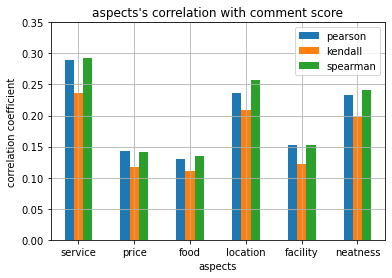

In [18]:
# 计算相关系数并可视化
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('scored sampled data.csv')

aspects = ['service', 'price', 'food', 'location', 'facility', 'neatness']
corr = pd.DataFrame(columns=['aspect','pearson', 'kendall', 'spearman'])

for i in range(len(aspects)):
    _df = pd.DataFrame(columns=['score', aspects[i]])
    _df['score'] = df['score']
    _df[aspects[i]] = df[aspects[i]]
    corr.loc[i+1] = [aspects[i], _df.corr('pearson').iloc[0,1], _df.corr('kendall').iloc[0,1], _df.corr('spearman').iloc[0,1]]

corr = corr.set_index(corr['aspect'])
corr = corr.drop(['aspect'], axis=1)
fig = corr.plot.bar(rot=0, ylabel='correlation coefficient', xlabel='aspects',grid=True,title='aspects\'s correlation with comment score',ylim=(0,0.35)).get_figure()
fig.savefig('plots/correlation.jpg')
corr

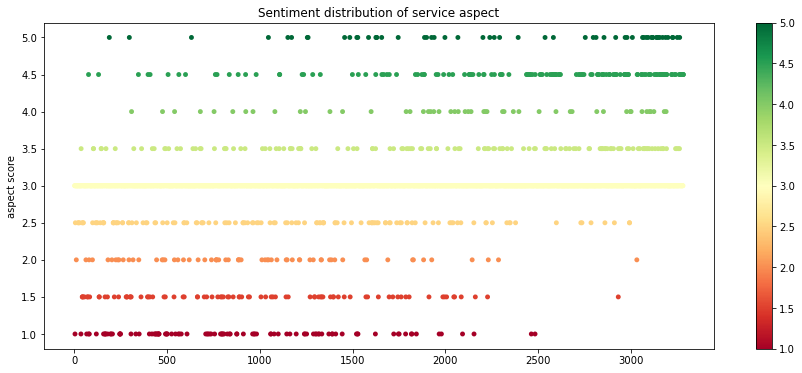

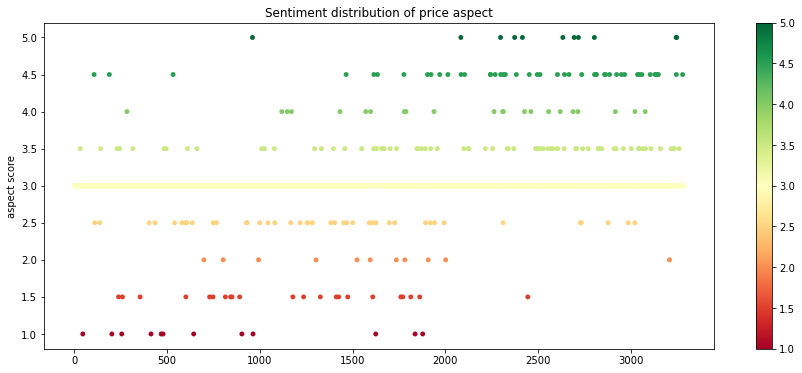

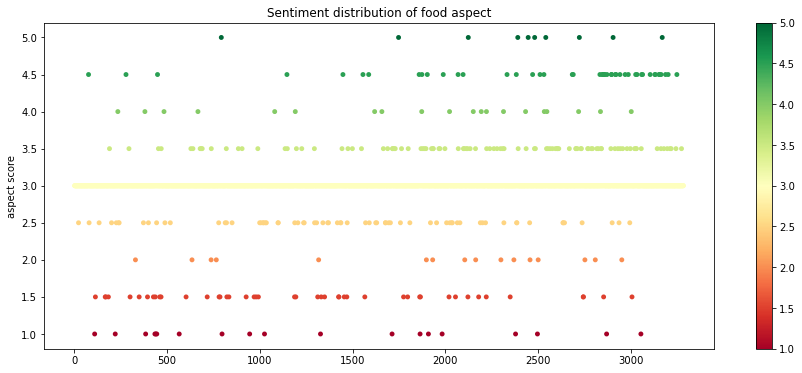

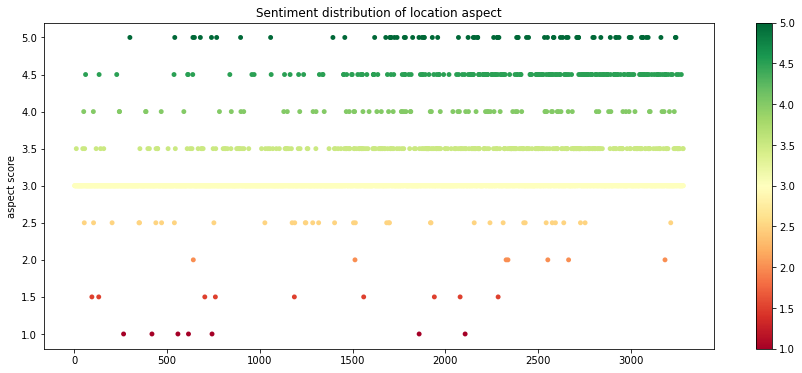

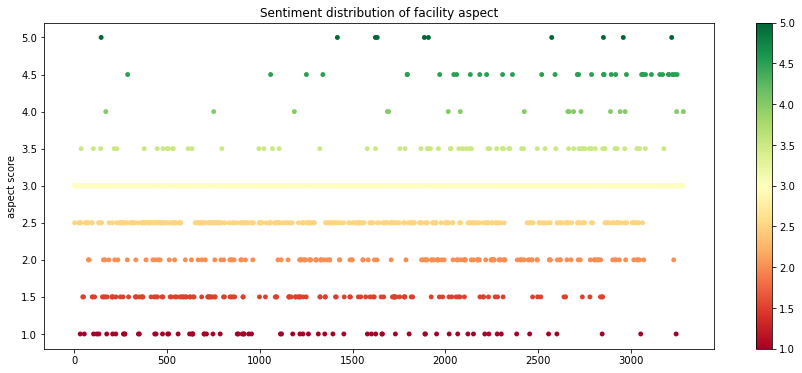

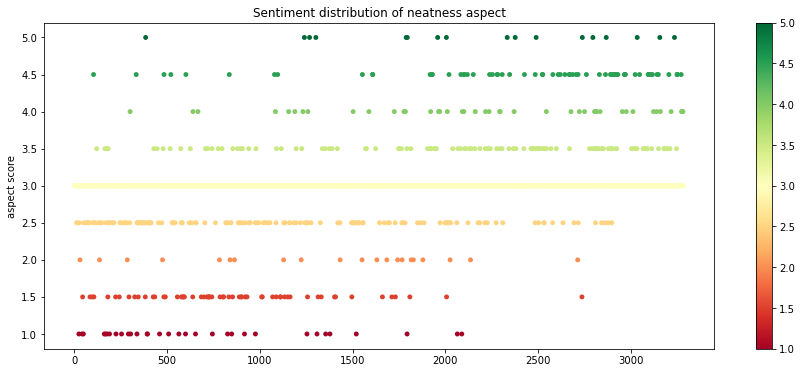

In [7]:
# 可视化方面与评分的关系
import numpy as np 
import matplotlib.pyplot as plt 
  
df = pd.read_csv('scored sampled data.csv')

aspects = ['service', 'price', 'food', 'location', 'facility', 'neatness']

for aspect in aspects:
    score = df[aspect].iloc[1:]

    fig=plt.figure(figsize=(15,6))
    number = np.linspace(1,3284,3284,dtype=int)
    plt.scatter(x=number,y=score,c=score,cmap="RdYlGn",edgecolor='none',s=24) 

    plt.title('Sentiment distribution of ' + aspect + ' aspect')
    plt.ylabel('aspect score')
    plt.colorbar(orientation="vertical") 
    plt.savefig('plots/'+aspect+'.jpg')
    plt.show()

# 酒店回复分析

In [49]:
import jieba.analyse as analyse
jieba.analyse.set_stop_words('dict/stopwords.txt')

df = pd.read_csv('scored sampled data.csv')

pos_replies = df[df['score']>3.0]
neg_replies = df[df['score']<3.0]

pos_replies = pos_replies['reply'].drop_duplicates().values.tolist()
joined_pos_replies = "".join(pos_replies)

neg_replies = neg_replies['reply'].drop_duplicates().values.tolist()
joined_neg_replies = "".join(neg_replies)

print('Top 20 keywords in positive replies:')
for x, w in analyse.extract_tags(joined_pos_replies, topK=20, withWeight=True):
    pos_counter[x] = w
    print('%s %s' % (x, w))

print('\nTop 20 key words in negative replies:')
for x, w in analyse.extract_tags(joined_neg_replies, topK=20, withWeight=True):
    neg_counter.append((x,w))
    print('%s %s' % (x, w))

Top 20 keywords in positive replies:
酒店 0.2686138498416734
感谢您 0.2415225761772637
入住 0.22908604577313155
光临 0.1542585209113369
尊敬 0.13591855578552528
您好 0.1356311795815484
期待 0.13058100755574453
宾客 0.12887464480534583
再次 0.10667325537646058
下次 0.08587879541899389
体验 0.082666776255842
服务 0.07732926452605124
贝尔特 0.07504497615544758
客人 0.07394526353736577
设施 0.05697803323911199
选择 0.05137941841835411
房间 0.04975912963492877
小纽 0.04763128623564938
希望 0.04685058097304211
衷心 0.04583751457294695

Top 20 key words in negative replies:
入住 0.30369254569898124
酒店 0.24655774206923775
感谢您 0.17705407396343736
尊敬 0.11781207921138032
宾客 0.11461561790028194
体验 0.11142477860869474
光临 0.10781858980666123
您好 0.10565868104555658
期待 0.09178003898308665
再次 0.08934106828843844
抱歉 0.08117120788064826
客人 0.07593285702368173
祝您 0.0714219801849676
服务 0.06526329173552733
下次 0.06395896656842665
愉快 0.06040030809588168
房间 0.059393543374604514
反馈 0.05731514514838143
问题 0.05617732459707181
带来 0.04945391424011798
